In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

In [2]:
datasets = ['tabula-muris-heart', 'tabula-muris-marrow_P7_3', 'peripheal-blood']#, 'zheng-4', 'zheng-8']

data_path = {}
labels_path = {}
markers_path = {}
scores_path = {}
for dataset in datasets:
    data_path[dataset] = "../dataset/{}-filtered/10X/".format(dataset)
    labels_path[dataset] = "../dataset/{}-filtered/labels.csv".format(dataset)
    markers_path[dataset] = "../results/aggregate/{}/markers.csv".format(dataset)
    scores_path[dataset] = "../results/{}/clf_scores.pickle".format(dataset)

In [3]:
adata = {}
for dataset in datasets:
    adata[dataset] = sc.read_10x_mtx(
        data_path[dataset],
        var_names='gene_symbols',
        cache=False
    )

In [4]:
y_df = {}
for dataset in datasets:
    y_df[dataset] = pd.read_csv(labels_path[dataset], index_col=0)
    y_df[dataset]

In [5]:
for dataset in datasets:
    y_df[dataset] = pd.DataFrame(adata[dataset].obs_names, columns=["cell"]).join(y_df[dataset], on="cell")
    y_df[dataset]

In [6]:
mask = {}
for dataset in datasets:
    mask[dataset] = ~np.isnan(np.array(y_df[dataset]['cluster.ids'])).reshape(-1)
    print(dataset, mask[dataset][mask[dataset]==False])

tabula-muris-heart []
tabula-muris-marrow_P7_3 []
peripheal-blood []


In [7]:
for dataset in datasets:
    print(dataset, y_df[dataset]['cluster.ids'][mask[dataset]])

tabula-muris-heart 0      4
1      5
2      4
3      1
4      5
      ..
612    2
613    2
614    3
615    4
616    5
Name: cluster.ids, Length: 617, dtype: int64
tabula-muris-marrow_P7_3 0        4
1       11
2       13
3        7
4        5
        ..
1865     1
1866     3
1867     6
1868    12
1869    12
Name: cluster.ids, Length: 1870, dtype: int64
peripheal-blood 0       7
1       7
2       7
3       1
4       1
       ..
3653    1
3654    3
3655    7
3656    2
3657    7
Name: cluster.ids, Length: 3658, dtype: int64


In [8]:
y = {}
for dataset in datasets:
    y[dataset] = np.array(y_df[dataset]['cluster.ids'][mask[dataset]].astype(int))

In [9]:
clusters = {}
counts = {}
for dataset in datasets:    
    clusters[dataset], counts[dataset] = np.unique(y[dataset], return_counts=True)
    print(clusters[dataset], counts[dataset])

[1 2 3 4 5] [ 98  60  62 172 225]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] [ 34  27  89  33 372 203 168  67 110 124 273 161 137  72]
[ 1  2  3  4  5  6  7  8  9 10 11] [ 795  190  639   74  119  295 1096  263   48   98   41]


In [10]:
weights = {}
for dataset in datasets:
    weights[dataset] = counts[dataset][np.argsort(clusters[dataset])]

In [11]:
import sys
from joblib import Parallel, delayed
def apply_classifier(X, y):
    clf = RandomForestClassifier(n_jobs=2)
    y_pred = cross_val_predict(clf, X, y, cv=5)
    f1 = f1_score(y, y_pred)
    return f1

markers_df = {}
tools = {}
for dataset in datasets:
    markers_df[dataset] = pd.read_csv(markers_path[dataset])
    tools[dataset] = markers_df[dataset].tool.unique()

def classifier(dataset):
    print('Started {}'.format(dataset), file=sys.stderr)
    f1_markers = {}
    f1_markers[dataset] = {}
    for tool in tools[dataset]:
        f1_markers_tool = []
        for cluster in clusters[dataset]:
            y_bin = np.array(y[dataset]==cluster, dtype=int)
            markers = markers_df[dataset][
                (markers_df[dataset]['cluster']==cluster) & (markers_df[dataset]['tool']==tool)
            ].gene.unique()
            X_markers = adata[dataset][mask[dataset], markers].X.toarray()
            f1_markers_tool.append(apply_classifier(X_markers, y_bin))
        if tool not in f1_markers[dataset]:
            f1_markers[dataset][tool] = []
        f1_markers[dataset][tool] = round((weights[dataset]*np.array(f1_markers_tool)).sum()/weights[dataset].sum(), 3)
    return f1_markers

f1_markers = Parallel(n_jobs=len(tools))(delayed(classifier)(dataset) for dataset in datasets)
f1_markers2 = {}
for i, el in enumerate(f1_markers):
        f1_markers2[list(el.keys())[0]] = el[list(el.keys())[0]]
f1_markers = f1_markers2

Started peripheal-blood
Started tabula-muris-marrow_P7_3
Started tabula-muris-heart


In [12]:
f1_weighted = {}
for dataset in datasets:
    f1_all = []
    for cluster in clusters[dataset]:
        y_bin = np.array(y[dataset]==cluster, dtype=int)
        X_all = adata[dataset][mask[dataset], ].X.toarray()
        f1_all.append(apply_classifier(X_all, y_bin))
    f1_weighted[dataset] = round((weights[dataset]*np.array(f1_all)).sum()/weights[dataset].sum(), 3)

In [13]:
for dataset in datasets:
    print("F1 weighted when training on markers dataset {}".format(dataset))
    print(f1_markers[dataset])
    print("F1 weighted when training on all genes dataset {}".format(dataset))
    print(f1_weighted[dataset])
    pd.DataFrame.from_dict(
      data=f1_markers[dataset],
      orient='index').to_csv(
        "../results/{}/clf_f1.csv".format(dataset), 
        header=['f1'], 
        index=False)

F1 weighted when training on markers dataset tabula-muris-heart
{'monocle': 0.97, 'scanpy': 0.974, 'seurat': 0.973, 'scvi': 0.972}
F1 weighted when training on all genes dataset tabula-muris-heart
0.984
F1 weighted when training on markers dataset tabula-muris-marrow_P7_3
{'monocle': 0.868, 'scanpy': 0.882, 'seurat': 0.887, 'scvi': 0.881}
F1 weighted when training on all genes dataset tabula-muris-marrow_P7_3
0.874
F1 weighted when training on markers dataset peripheal-blood
{'monocle': 0.81, 'scanpy': 0.821, 'seurat': 0.818, 'scvi': 0.802}
F1 weighted when training on all genes dataset peripheal-blood
0.784


In [15]:
# rank genes using recursive feature elimination
for dataset in datasets:
    selector = RFE(RandomForestClassifier(n_jobs=4), n_features_to_select=50, step=0.5)
    cluster_features = {}
    X_all = adata[dataset][mask[dataset], ].X.toarray()
    y_bin = np.array(y[dataset]==cluster, dtype=int)
    for cluster in clusters[dataset]:
        selector.fit(X_all, y_bin)
        sorted_idx = (selector.ranking_).argsort()
        rfe_features_sorted = adata[dataset].var_names[sorted_idx]
        cluster_features[cluster] = rfe_features_sorted
    pd.DataFrame(cluster_features).to_csv("../results/{}/rfe_ranking.csv".format(dataset), index=False)

In [16]:
def process(dataset, tool):
    step = 1
    tmp_scores = {}
    for cluster in clusters[dataset]:
        n_markers = 50
        y_bin = np.array(y[dataset]==cluster, dtype=int)
        for i in range(step, n_markers+step, step):
            markers = markers_df[dataset][
            (markers_df[dataset]['cluster']==cluster) & (markers_df[dataset]['tool']==tool) & (markers_df[dataset]['rank']<=i)].gene.unique()
            X = adata[dataset][mask[dataset], markers].X.toarray()
            f1 = apply_classifier(X, y_bin)
            if tool not in tmp_scores:
                tmp_scores[tool] = {}
            if cluster not in tmp_scores[tool]:
                tmp_scores[tool][cluster] = {}
            if 'scores' not in tmp_scores[tool][cluster]:
                tmp_scores[tool][cluster]['scores'] = []
            tmp_scores[tool][cluster]['scores'].append(f1)
    
        # mean for each cluster
        print("Cluster {} of dataset {} done for tool {}".format(cluster, dataset, tool), file=sys.stderr)
    return tmp_scores

In [17]:
# -------- train with increasing # of features taken from markers rank --------
step = 1
n_markers = 50
import pickle, os
scores = {}
for dataset in datasets:
    print('Started {}'.format(dataset), file=sys.stderr)
    if os.path.exists(scores_path[dataset]):
        print('Loading scores for {}'.format(dataset), file=sys.stderr)
        with open(scores_path[dataset], 'rb') as handle:
            scores[dataset] = pickle.load(handle)
    else:
        print('Computing scores for {}'.format(dataset), file=sys.stderr)
        scores2 = {}
        scores3 = Parallel(n_jobs=len(tools[dataset]))(delayed(process)(dataset, tool) for tool in tools[dataset])
        for i, el in enumerate(scores3):
            scores2[list(el.keys())[0]] = el[list(el.keys())[0]]
        scores[dataset] = scores2
        for tool in tools[dataset]:
            for i in range(step, n_markers+step, step):
                sumForI = 0
                for j, cluster in enumerate(clusters[dataset]):
                    sumForI += (scores[dataset][tool][cluster]['scores'][i-1] * counts[dataset][j])
                if tool not in scores[dataset]:
                    scores[dataset][tool] = {}
                if 'TotalMean' not in scores[dataset][tool]:
                    scores[dataset][tool]['TotalMean'] = []
                scores[dataset][tool]['TotalMean'].append(sumForI/np.sum(counts[dataset]))
        with open(scores_path[dataset], 'wb') as handle:
            pickle.dump(scores[dataset], handle, protocol=pickle.HIGHEST_PROTOCOL)   

Started tabula-muris-heart
Loading scores for tabula-muris-heart
Started tabula-muris-marrow_P7_3
Loading scores for tabula-muris-marrow_P7_3
Started peripheal-blood
Loading scores for peripheal-blood


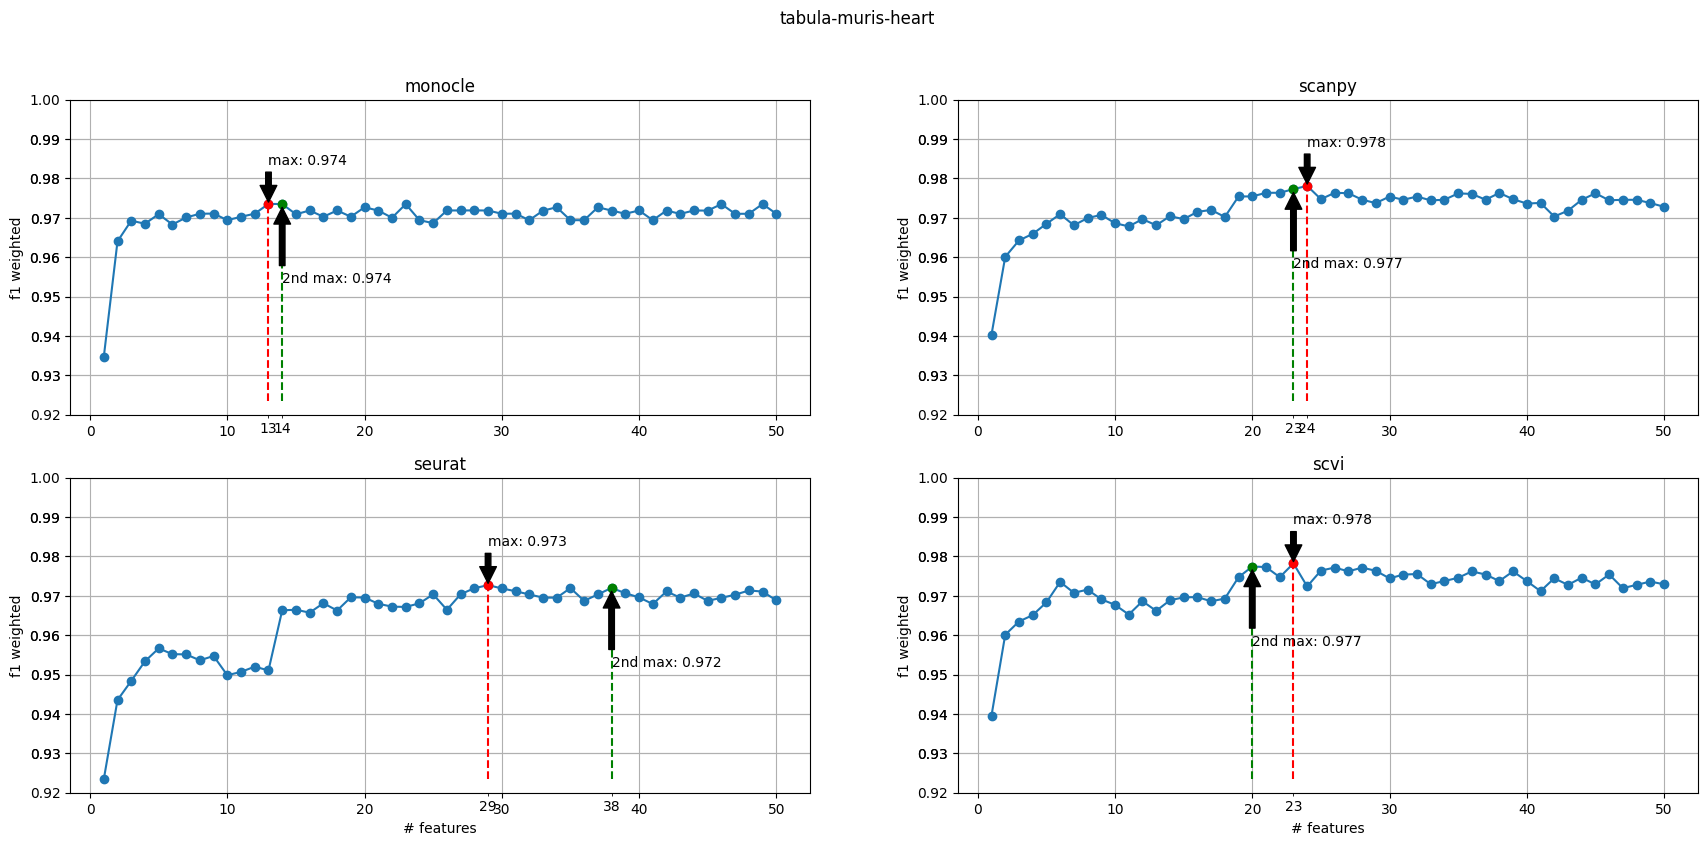

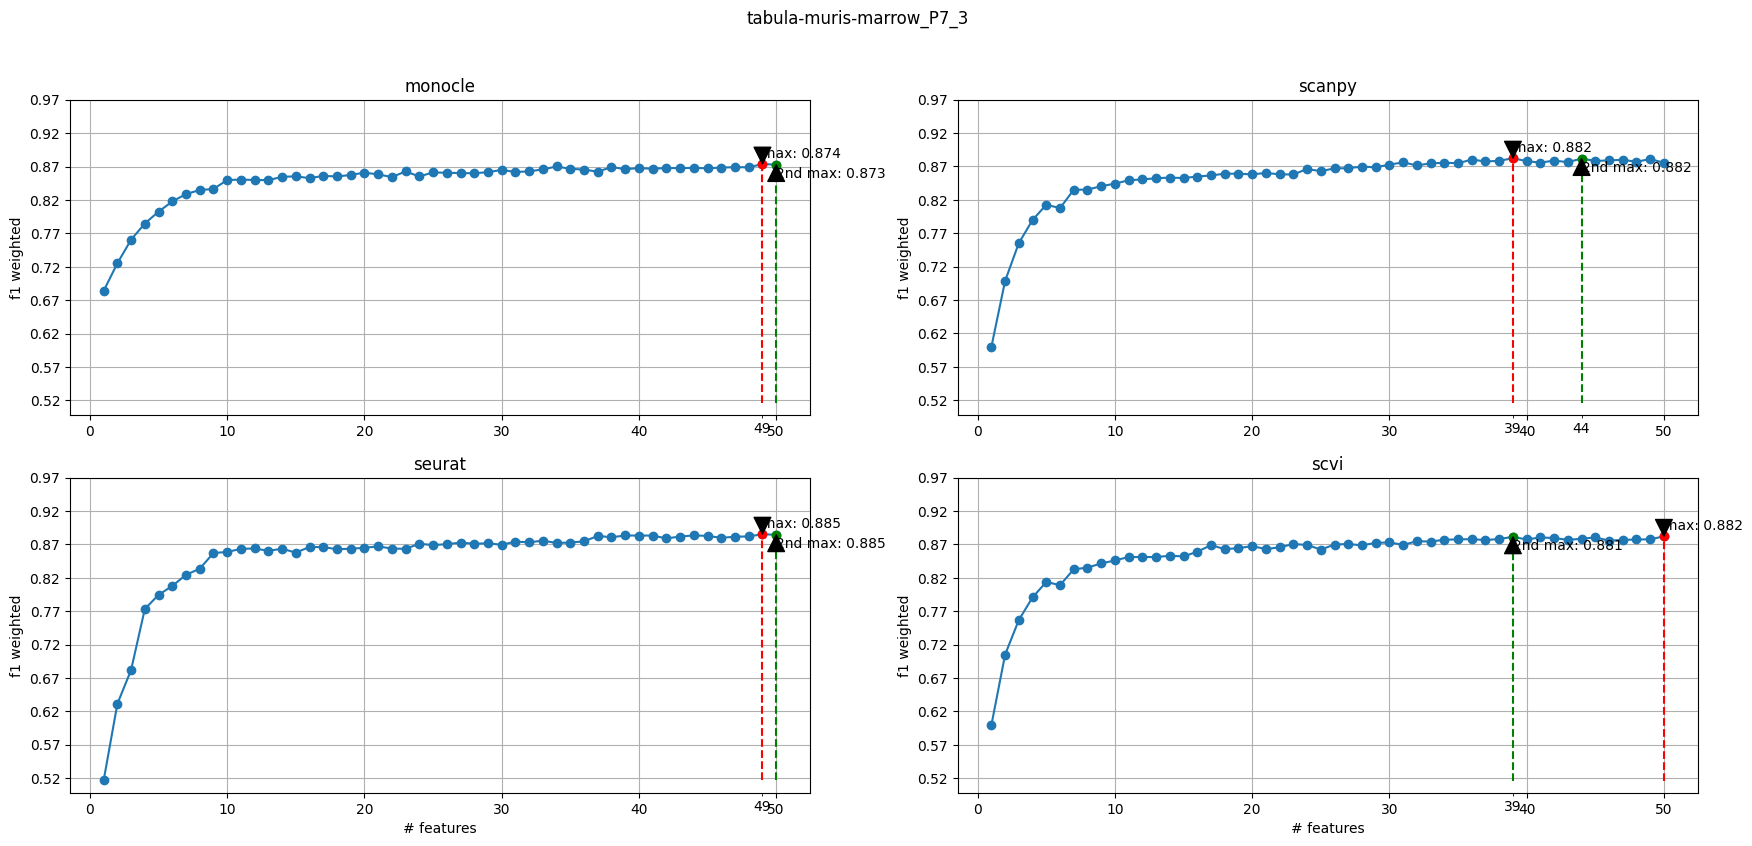

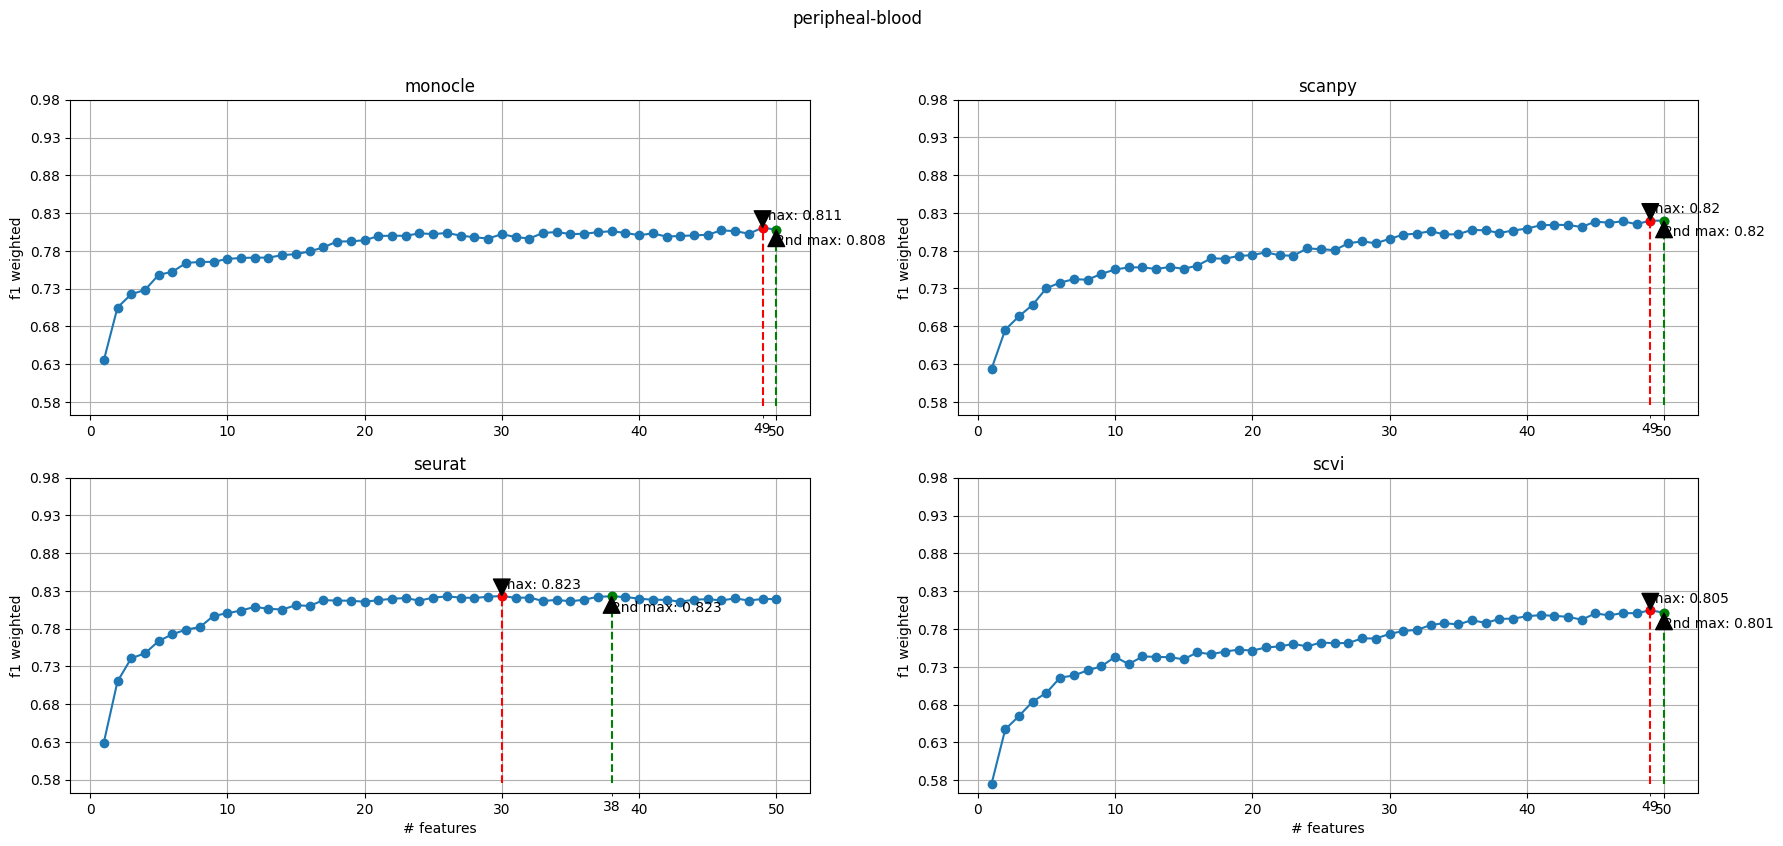

In [18]:
for dataset in datasets:
    fig, ax = plt.subplots(2, 2, figsize=(21, 9))
    fig.suptitle(dataset)
    # min value for the dataset
    min_val = np.min([np.min(scores[dataset][tool]['TotalMean']) for tool in tools[dataset]])
    for i, tool in enumerate(tools[dataset]):
        max_i = np.argmax(scores[dataset][tool]['TotalMean'])
        second_max = np.argsort(scores[dataset][tool]['TotalMean'])[-2]
        
        ax[i//2, i%2].plot([i for i in range(step, n_markers+step, step)], scores[dataset][tool]['TotalMean'], marker='o')
        
        # print max max in red
        ax[i//2, i%2].plot([max_i+1], [scores[dataset][tool]['TotalMean'][max_i]], marker='o', color='red')
        
        # print second max in green
        ax[i//2, i%2].plot([second_max+1], [scores[dataset][tool]['TotalMean'][second_max]], marker='o', color='green')
        
        # annotation for max
        ax[i//2, i%2].annotate('max: {}'.format(round(scores[dataset][tool]['TotalMean'][max_i], 3)), xy=(max_i+1, scores[dataset][tool]['TotalMean'][max_i]), xytext=(max_i+1, scores[dataset][tool]['TotalMean'][max_i]+0.01), arrowprops=dict(facecolor='black', shrink=0.05))
        
        # annotation for second max
        ax[i//2, i%2].annotate('2nd max: {}'.format(round(scores[dataset][tool]['TotalMean'][second_max], 3)), xy=(second_max+1, scores[dataset][tool]['TotalMean'][second_max]), xytext=(second_max+1, scores[dataset][tool]['TotalMean'][second_max]-0.02), arrowprops=dict(facecolor='black', shrink=0.05))
        ax[i//2, i%2].set_ylabel("f1 weighted")
        
        # Only last two plots have x label (it's the same for all)
        if (i>1):
            ax[i//2, i%2].set_xlabel("# features")
        # print x tick for max 
        ax[i//2, i%2].plot([max_i+1, max_i+1], [min_val, scores[dataset][tool]['TotalMean'][max_i]], linestyle='--', color='red')
        ax[i//2, i%2].plot([second_max+1, second_max+1], [min_val, scores[dataset][tool]['TotalMean'][second_max]], linestyle='--', color='green')
        ax[i//2, i%2].set_xticks([max_i+1, second_max+1], [max_i+1, second_max+1], minor=True)
        # Same scale for all plots
        ax[i//2, i%2].set_yticks([round(i, 2) for i in np.arange(min_val, 1, (0.005 if min_val > 0.9 else 0.05))])
        # Set title
        ax[i//2, i%2].set_title(tool)
        ax[i//2, i%2].grid()
        plt.savefig('../results/{}/clf_plots.eps'.format(dataset))
        plt.savefig('../results/{}/clf_plots.png'.format(dataset))